<a href="https://colab.research.google.com/github/dqniellew1/NFT_pricing_model/blob/main/Penguins_data_%26_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [741]:
import pandas as pd
import numpy as np
import json
import requests
import math
from tqdm.auto import tqdm
from itertools import chain
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb
import matplotlib.style as style
import joblib


%matplotlib inline

In [ ]:
#@title
token_ids = [x for x in range(0,8888)]

In [ ]:
#@title
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
#@title
id_groups = list(chunks(token_ids, 50))

In [ ]:
#@title
penguin_list = []
for id in tqdm(id_groups):
    url = "https://api.opensea.io/api/v1/assets"

    querystring = {"token_ids": id, "asset_contract_address":"0xbd3531da5cf5857e7cfaa92426877b022e612cf8","order_direction":"asc","offset":"0","limit":"50"}

    response = requests.request("GET", url, params=querystring).json()

    penguin_list.append(response)



  0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
url = "https://api.opensea.io/api/v1/collection/pudgypenguins"

querystring = {"offset":0, "limit": 1}

stat_response = requests.request("GET", url, params=querystring).json()

stats = pd.json_normalize(stat_response['collection'])[['stats.floor_price']]
#['stats.seven_day_volume','stats.seven_day_change','stats.seven_day_sales','stats.seven_day_average_price','stats.num_owners']

In [696]:
def process_data(nft_asset_list, stats):
    penguins = [x['assets'] for x in nft_asset_list]
    df_penguins = pd.DataFrame(list(chain(*penguins)))

    df_penguins['sell_orders'] = df_penguins['sell_orders'].apply(lambda x: {} if pd.isna(x) else x)
    so = pd.json_normalize(list(chain(*df_penguins['sell_orders'])))
    so['listing_token_price'] = (so['current_price'].astype(float)/10**so['payment_token_contract.decimals'].astype(float))
    so['listing_usd_price'] = (so['listing_token_price'].astype(float) * so['payment_token_contract.usd_price'].astype(float))    
    so['listing_eth_price'] = (so['listing_usd_price'].astype(float) / so['payment_token_contract.usd_price'].median().astype(float))
    so = so[['metadata.asset.id','listing_usd_price', 'listing_eth_price']]

    df_penguins = df_penguins.merge(so, how='left', left_on= 'token_id', right_on='metadata.asset.id')

    cols = ['id','token_id','num_sales','image_url', 'permalink', 'listing_usd_price', 'listing_eth_price'] #'listing_usd_price', 'listing_eth_price'
    desc = df_penguins[cols]

    owner = pd.json_normalize(df_penguins['owner'])['address']

    traits = pd.json_normalize(list(chain(*df_penguins['traits']))).pivot(columns='trait_type', values=['value', 'trait_count']).apply(lambda x: pd.Series(x.dropna().values))

    df_penguins['last_sale'] = df_penguins['last_sale'].apply(lambda x: {} if pd.isna(x) else x)
    last_sale_cols = ['created_date','last_sold_token','last_sold_usd','last_sold_eth','payment_token.usd_price']
    last_sale = pd.json_normalize(df_penguins['last_sale'])
    last_sale['last_sold_token'] = last_sale['total_price'].astype(float)/10**last_sale['payment_token.decimals']
    last_sale['last_sold_usd'] = last_sale['payment_token.usd_price'].astype(float) * last_sale['last_sold_token'].astype(float)
    last_sale['last_sold_eth'] = (last_sale['last_sold_usd'].astype(float) / last_sale['payment_token.usd_price'].median().astype(float))
    last_sale.loc[:, ['last_sold_eth']] = last_sale['last_sold_eth'].astype(float).fillna(0.03)
    last_sale['last_sold_usd'] = last_sale['payment_token.usd_price'].median().astype(float) * last_sale['last_sold_eth'].astype(float)

    last_sale = last_sale[last_sale_cols]
    last_sale.columns = ['last_sold_date','last_sold_token','last_sold_usd', 'last_sold_eth', 'payment_token.usd_price']
    last_sale['last_sold_date'] = pd.to_datetime(last_sale['last_sold_date'])
    last_sale['last_sold_date'].fillna(value=pd.to_datetime('2021/07/22'), inplace=True) 
    last_sale['last_sold_date'] = last_sale['last_sold_date'].dt.normalize()
    last_sale['mean_sale_eth_day'] = last_sale.groupby('last_sold_date')['last_sold_eth'].transform('mean')
    last_sale['max_sale_eth_day'] = last_sale.groupby('last_sold_date')['last_sold_eth'].transform('max')
    last_sale['mean_sale_usd_day'] = last_sale['mean_sale_eth_day'] * last_sale['payment_token.usd_price'].median().astype(float)
    last_sale['max_sale_usd_day'] = last_sale['max_sale_eth_day'] * last_sale['payment_token.usd_price'].median().astype(float)

    penguins_combine = pd.concat([desc, owner, traits, last_sale], axis=1)
    new_name = ['id','token_id','num_sales','image_url','permalink', 'listing_usd_price', 'listing_eth_price',
                'address','Background','Body','Face','Head','Skin','Background_count','Body_count',
                'Face_count','Head_count','Skin_count','last_sold_date','last_sold_token','last_sold_usd','last_sold_eth','payment_token.usd_price',
                'mean_sale_eth_day','max_sale_eth_day','mean_sale_usd_day','max_sale_usd_day']
    penguins_combine.columns = new_name
    penguins_combine.loc[penguins_combine['Head'] == 'None', ['Head_count']] = '0'
    for col in ('Background','Body','Face','Head','Skin'):
        penguins_combine[col+'1'] = penguins_combine[col].apply(lambda x: 1 if x != 'None' else 0)
    penguins_combine['Trait_count'] = penguins_combine['Background1'] + penguins_combine['Body1'] + penguins_combine['Face1'] + penguins_combine['Head1'] + penguins_combine['Skin1']
    penguins_combine.drop(['Background1','Body1','Face1','Head1','Skin1'], axis=1, inplace=True)

    penguins_combine['rarity_score'] = penguins_combine['Background_count'].astype(int) + penguins_combine['Body_count'].astype(int) + penguins_combine['Face_count'].astype(int) + penguins_combine['Head_count'].astype(int) + penguins_combine['Skin_count'].astype(int)
    penguins_combine['number_owned'] = penguins_combine.groupby('address')['address'].transform('count')
    trait_count = ['Background_count','Body_count','Face_count','Head_count','Skin_count']
    for col in trait_count:
        penguins_combine[col] = penguins_combine[col].astype(float)/8888

    pengu_all = pd.concat([penguins_combine,stats],1).ffill()

    pengu_all['stats.floor_price_usd'] = pengu_all['stats.floor_price'].astype(float) * pengu_all['payment_token.usd_price'].astype(float).median()
    pengu_all['mint_multiple'] = pengu_all['last_sold_eth'].astype(float) / 0.03
    pengu_all['listing_multiple'] = pengu_all['listing_usd_price'].astype(float) / pengu_all['stats.floor_price_usd'].astype(float)

    pengu_all['last_sold_usd_log'] = pengu_all['last_sold_usd'].apply(lambda x: np.log1p(x))
    pengu_all['last_sold_eth_log'] = pengu_all['last_sold_eth'].apply(lambda x: np.log1p(x))
    #pengu_all['listing_usd_log'] = pengu_all['listing_usd_price'].apply(lambda x: np.log1p(x))
    pengu_all['num_sold_day'] = pengu_all.groupby('last_sold_date')['num_sales'].transform('count')

    num_cols = ['num_sales', 'Background_count', 'Body_count','Face_count', 'Head_count', 
            'Skin_count','rarity_score','number_owned', 'mint_multiple']

    for col in num_cols:
        # do not fill numerical columns
        pengu_all.loc[:, col] = pengu_all[col].astype(float).fillna(0)
    
    pengu_all['Trait_count_avg_price'] = pengu_all.groupby('Trait_count')['last_sold_eth'].transform('mean')
    pengu_all['Trait_count_avg_usd_price'] = pengu_all['Trait_count_avg_price'] * pengu_all['payment_token.usd_price'].astype(float).median()

    pengu_all.loc[pengu_all['listing_eth_price'] > 150, ['listing_eth_price']] = '200'
    pengu_all['listing_usd_price'] = pengu_all['listing_eth_price'].astype(float) * pengu_all['payment_token.usd_price'].astype(float).median()
    pengu_all['listing_usd_price'].fillna(pengu_all['listing_usd_price'].median(), inplace=True)
    pengu_all['listing_multiple'] = pengu_all['listing_usd_price'].astype(float) / pengu_all['stats.floor_price_usd'].astype(float)

    return pengu_all

In [697]:
pengus = process_data(penguin_list, stats)

In [675]:
# export as csv
#pengus.to_csv('pengus.csv')

## Modeling

In [698]:
df = pengus.copy()

In [709]:
features = [f for f in df.columns if f not in ('id','token_id','image_url', 'permalink','address', 
                                                   'last_sold_token','last_sold_eth','last_sold_usd','listing_eth_price',
                                                   'payment_token.usd_price', 'stats.floor_price',
                                                   'last_sold_usd_log','stats.num_owners',
                                                   'Background','Body', 'Face', 'Head', 'Skin','preds_usd', 'last_sold_date',
                                               'mean_sale_eth_day','max_sale_eth_day','Trait_count_avg_price')]

In [710]:
train_df, test_df = model_selection.train_test_split(df, train_size = 0.8)

In [711]:
def create_folds(data):
    # create folds for training data
    # create kfold column and fill -1
    data['kfold'] = -1

    # randomize data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate the number of bins by Sturge's rule
    # Take floor or round it
    #num_bins = int(np.floor(1 + np.log2(len(data))))

    # bin targets
    # cut to sort data into bins
    data.loc[:, "bins"] = pd.cut(
        data["last_sold_usd"], bins=20, labels=False
    )

    # initiate kfold
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new k-fold column
    # use bins for target since regression
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f

    # drop the bins column
    data = data.drop("bins", axis=1)
    # return dataframe with folds
    return data

In [712]:
df_pengu = create_folds(train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [713]:
# # Label encode the features
# for col in features:
#     if col in cat_cols:
#         # initialize LabelEncoder on every feature column
#         lbl = preprocessing.LabelEncoder()

#         # fit on full data
#         lbl.fit(pd.concat([df_pengu[col], test_df[col]], axis=0, sort=False))
#         np.save('pengu_cat_class.npy', lbl.classes_)

#         # transform on full data/ test
#         pengu_all.loc[:, col] = lbl.transform(pengu_all[col])
#         df_pengu.loc[:, col] = lbl.transform(df_pengu[col])
#         test_df.loc[:, col] = lbl.transform(test_df[col])

In [714]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=40,
        max_samples=2500, max_features=0.5,
        min_samples_leaf=8, oob_score=True)

In [715]:
def run(fold, df, model):
    # get training data with folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data with folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # fit model on training data
    model.fit(x_train, df_train.last_sold_usd_log.values)
    
    # get predictions from validation data
    valid_preds = model.predict(x_valid)

    # get scores
    mse = metrics.mean_squared_error(df_valid.last_sold_usd_log.values, valid_preds)
    mae = metrics.mean_absolute_error(df_valid.last_sold_usd_log.values, valid_preds)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(df_valid.last_sold_usd_log.values, valid_preds)
    # print score
    print(f"Fold = {fold}, RMSE = {rmse}, MSE = {mse}, r2 = {r2}, MAE = {mae}")

In [716]:
#  market data in usd
for fold_ in range(5):
    run(fold_, df_pengu, model)

Fold = 0, RMSE = 0.039784121466262375, MSE = 0.0015827763208423186, r2 = 0.9995034837137039, MAE = 0.012647758610692917
Fold = 1, RMSE = 0.03594959020952308, MSE = 0.0012923730362326379, r2 = 0.9996103200842161, MAE = 0.01138580260296327
Fold = 2, RMSE = 0.03691344701337381, MSE = 0.0013626025704091558, r2 = 0.9995765319923361, MAE = 0.010753877059116968
Fold = 3, RMSE = 0.15478895405915474, MSE = 0.023959620298727117, r2 = 0.9929252350782233, MAE = 0.01813154364577507
Fold = 4, RMSE = 0.07638004534253244, MSE = 0.005833911326527312, r2 = 0.9981576385770943, MAE = 0.012382996544913965


In [731]:
# fit full model
model.fit(df[features], df.last_sold_usd_log.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=2500, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [735]:
joblib.dump(model, "rf_ppg_model.joblib")

['rf_ppg_model.joblib']

In [736]:
loaded_rf = joblib.load("rf_ppg_model.joblib")

In [ ]:
# Predict using loaded model
preds_usd = np.stack([t.predict(df[features]) for t in loaded_rf.estimators_])
df['preds_usd'] = np.expm1(preds_usd[-1])

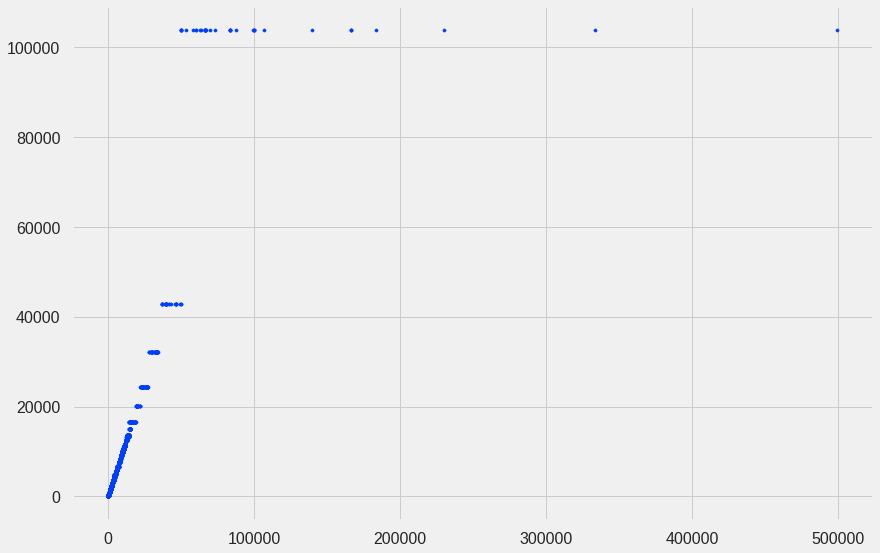

In [739]:
# predicted vs real price
plt.scatter(x='last_sold_usd', y='preds_usd', s=10, data=df)

In [737]:
# preds_usd = np.stack([t.predict(test_df[features]) for t in model.estimators_])
# test_df['preds_usd'] = np.expm1(preds_usd[-1])

In [755]:
# keep real & predicted prices
df['payment_token.usd_price'].fillna(df['payment_token.usd_price'].median(), inplace=True)
df['preds_eth'] = df['preds_usd'] / df['payment_token.usd_price'].astype(float)
df[['last_sold_usd','last_sold_eth', 'preds_usd', 'preds_eth']]

,last_sold_usd,last_sold_eth,preds_usd,preds_eth
0,99.9654,0.03,99.965400,0.030000
1,9330.1040,2.80,9331.634655,2.800459
2,833.0450,0.25,832.696442,0.249895
3,1666.0900,0.50,1653.955595,0.496358
4,1499.4810,0.45,1506.708010,0.452169
...,...,...,...,...
8883,6664.3600,2.00,6578.448271,1.974218
8884,11662.6300,3.50,11641.724050,3.493726
8885,11662.6300,3.50,11599.177877,3.480958
8886,8263.8064,2.48,8267.635770,2.481149


In [723]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [724]:
r_mse(preds_usd.mean(0), test_df['last_sold_usd_log'].values)

0.047235

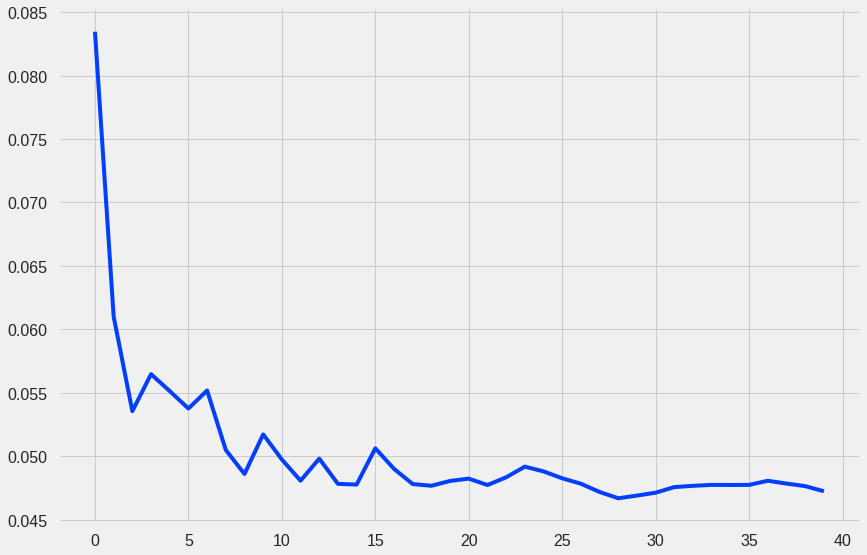

In [725]:
#usd
plt.plot([r_mse(preds_usd[:i+1].mean(0), test_df['last_sold_usd_log'].values) for i in range(40)]);

In [726]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [727]:
# usd
fi = rf_feat_importance(model, df_pengu[features])
fi[:10]

,cols,imp
13,mint_multiple,0.449974
15,last_sold_eth_log,0.425964
8,max_sale_usd_day,0.080014
7,mean_sale_usd_day,0.031240
16,num_sold_day,0.010368
5,Head_count,0.001383
0,num_sales,0.000455
3,Body_count,0.000160
10,rarity_score,0.000082
4,Face_count,0.000082


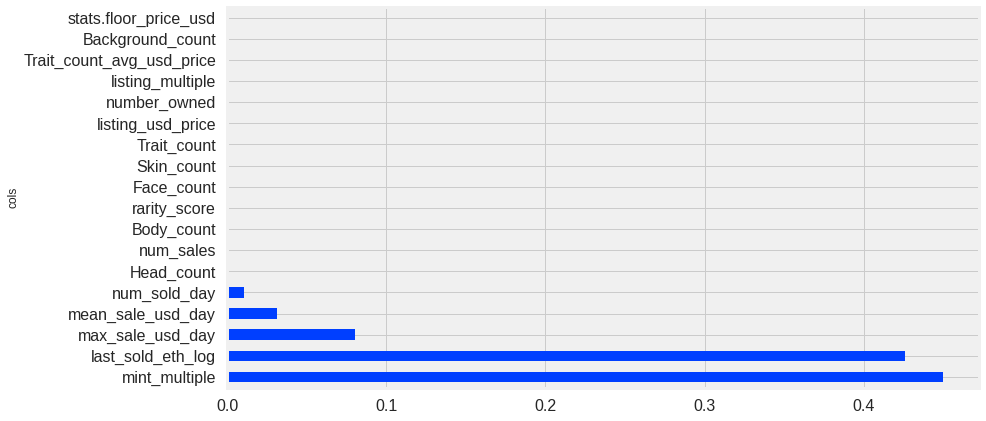

In [744]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);